In the following, I compare the predictive power of subsets of features using PCA, linear regression and cross-validation. The function below takes a list of sets of feature names (i.e. a list of sets of column names) and a list of numbers $n$. For each feature set and each value of $n$, it 
1. scales the features
3. performs PCA on them
4. regresses the target over the first $n$ principal components using OLS linear regression
5. computes the cross validation error for the regression

This is meant to give an "fair" comparison of different feature sets: for a fixed $n$, the model is given a fixed number of features (principal components) to regress over from each feature set. It should be noted that this analysis is limited: all stages (scaling, PCA, linear regression) are linear, and so it can not test for nonlinear relationships between the feature sets and the target variable.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

def compare_feature_sets_PCA(df, x_cols_list, y_col, num_PCs_list, num_folds):

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1111)

    # empty array to store cross validation errors, number of principal components changing across rows, feature sets across columns
    avg_cv_mse = np.empty((len(num_PCs_list)+1, len(x_cols_list)+1))
    avg_cv_mse[:] = np.nan

    # always store the error for 0 principal components, i.e. error in predicting the cv y values by the mean of the tt y values
    avg_cv_mse[0,0] = 0
    mseTotal = 0.0
    for tt_index, cv_index in kfold.split(df):
        df_tt = df.iloc[tt_index]
        df_cv = df.iloc[cv_index]
        predicted_y = np.ones(df_cv[y_col].shape) * np.mean(df_tt[y_col])
        mseTotal += mse(df_cv[y_col], predicted_y)
    avg_cv_mse[0,1:] = mseTotal / num_folds
    
    # loop over the number of principal components to use
    for (i, num_PCs) in enumerate(num_PCs_list):
        #print('n =', num_PCs)
        avg_cv_mse[i+1,0] = num_PCs
        pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components=num_PCs)), ('reg', LinearRegression())])

        # ... and over feature sets
        for (j, x_cols) in enumerate(x_cols_list):

            if len(x_cols) >= num_PCs: # If there are enough features in this feature set,
                mseTotal = 0.0
                # ... loop over splits,
                for tt_index, cv_index in kfold.split(df):
                    df_tt = df.iloc[tt_index]
                    df_cv = df.iloc[cv_index]
                    pca_pipe.fit(df_tt[x_cols], df_tt[y_col]) # ... fit on tt set,
                    predicted_y = pca_pipe.predict(df_cv[x_cols]) #  ... predict on cv set,
                    mseTotal += mse(df_cv[y_col], predicted_y)
                    
                avg_cv_mse[i+1,j+1] = mseTotal / num_folds  # .. and store average cv error.
            
    return avg_cv_mse

#### load all features
Note:
- for stoich45, I am droping columns with any NaNs.
- for the sine Coulomb matrix, I as using the density representation of the eigenspecturm. From an analysis similar to the one described and implemented above, it was shown to be more predictive than the list of the eigenvalues.

In [54]:
# load all data frames
df_train = pd.read_csv('../../data/datasets_main/train_hse06.csv', sep=',')

fingerprints_path = '../../data/QMOF/qmof_database/qmof_database/relaxed_structures_fingerprints/'
df_stoich45 = pd.read_csv(fingerprints_path + 'stoich45_fingerprints.csv', sep=',').dropna(axis=1)
df_stoich120 = pd.read_csv(fingerprints_path + 'stoich120_fingerprints.csv', sep=',')
df_sineSSD = pd.read_csv(fingerprints_path + 'sine_matrix_SSDs.csv', sep=',') # note: use the dentity representation of the sine eigenspectrum
df_ofm = pd.read_csv(fingerprints_path + 'ofm_fingerprints.csv', sep=',')

# merge all data frames
df_train = pd.merge(df_stoich45, df_train, left_on='MOF', right_on='qmof_id', how='right').merge(df_stoich120).merge(df_sineSSD).merge(df_ofm)
df_train.shape

(8648, 2705)

In [57]:
# store the column names for each feature subset
# ... numerical info columns for the original csv
cols_info = [col for col in df_train.columns if col.startswith('info')][3:]
# ... columns from 'fingerprints'
cols_stoich45 = df_stoich45.columns[1:].to_list()
cols_stoich120 = df_stoich120.columns[1:].to_list()
cols_sineSSD = df_sineSSD.columns[1:].to_list()
cols_ofm = df_ofm.columns[1:].to_list()

### composition features:
#### Does adding the info columns to stoich features improve the results?

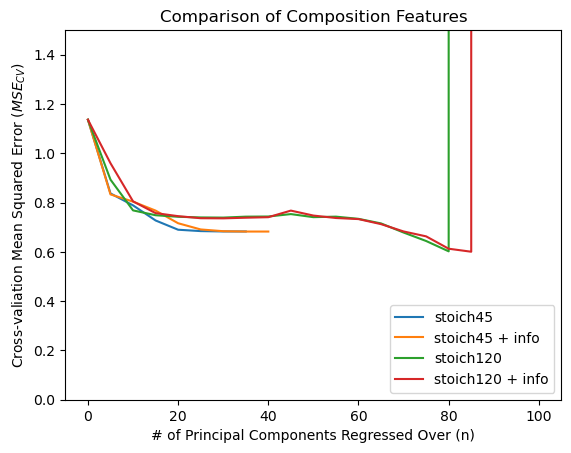

In [75]:
cv_mses = compare_feature_sets_PCA(df_train, [cols_stoich45, cols_stoich45 + cols_info, cols_stoich120, cols_stoich120 + cols_info], 'outputs.hse06.bandgap', np.arange(5,105,5), 8)
plt.plot(cv_mses[:,0],cv_mses[:,1:])
plt.ylim((0,1.5))
plt.xlabel('# of Principal Components Regressed Over (n)')
plt.ylabel('Cross-valiation Mean Squared Error ($MSE_{CV}$)')
plt.legend(['stoich45', 'stoich45 + info', 'stoich120', 'stoich120 + info'], loc='lower right')
plt.title('Comparison of Composition Features')
plt.show()

#### stoich 45 and stoich 120 combined or individual?

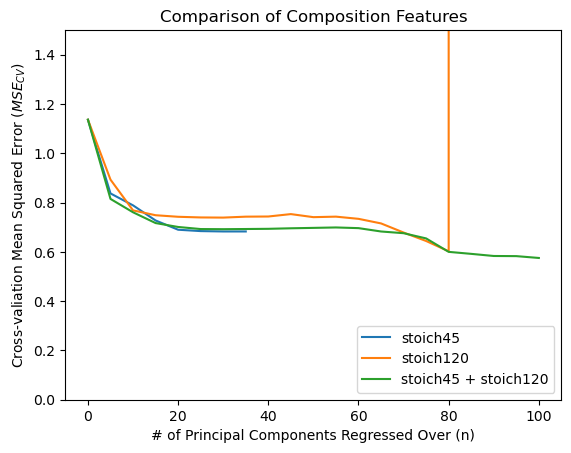

In [76]:
cv_mses = compare_feature_sets_PCA(df_train, [cols_stoich45, cols_stoich120, cols_stoich45 + cols_stoich120], 'outputs.hse06.bandgap', np.arange(5,105,5), 8)
plt.plot(cv_mses[:,0],cv_mses[:,1:])
plt.ylim((0,1.5))
plt.xlabel('# of Principal Components Regressed Over (n)')
plt.ylabel('Cross-valiation Mean Squared Error ($MSE_{CV}$)')
plt.legend(['stoich45', 'stoich120', 'stoich45 + stoich120'], loc='lower right')
plt.title('Comparison of Composition Features')
plt.show()

### structural features:
#### sine Coulomb matrix spectral density vs. orbital field matrix vs. both

n = 5
n = 10
n = 15
n = 20
n = 25
n = 30
n = 35
n = 40
n = 45
n = 50
n = 55
n = 60
n = 65
n = 70
n = 75
n = 80
n = 85
n = 90
n = 95
n = 100
n = 105
n = 110
n = 115
n = 120
n = 125
n = 130
n = 135
n = 140
n = 145
n = 150
n = 155
n = 160
n = 165
n = 170
n = 175
n = 180
n = 185
n = 190
n = 195
n = 200


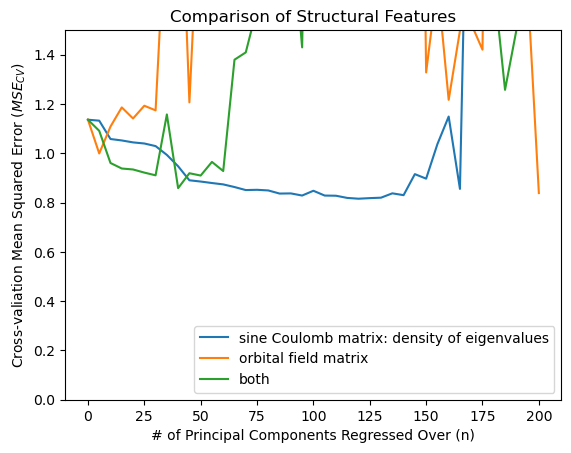

In [85]:
cv_mses = compare_feature_sets_PCA(df_train, [cols_sineSSD, cols_ofm, cols_sineSSD + cols_ofm], 'outputs.hse06.bandgap', np.arange(5,205,5), 8)
plt.plot(cv_mses[:,0],cv_mses[:,1:])
plt.ylim((0,1.5))
plt.xlabel('# of Principal Components Regressed Over (n)')
plt.ylabel('Cross-valiation Mean Squared Error ($MSE_{CV}$)')
plt.legend(['sine Coulomb matrix: density of eigenvalues', 'orbital field matrix', 'both'], loc='lower right')
plt.title('Comparison of Structural Features')
plt.show()

### combination of  features:
#### Is it useful to combine feature types?

n = 5
n = 10
n = 15
n = 20
n = 25
n = 30
n = 35
n = 40
n = 45
n = 50
n = 55
n = 60
n = 65
n = 70
n = 75
n = 80
n = 85
n = 90
n = 95
n = 100
n = 105
n = 110
n = 115
n = 120
n = 125
n = 130
n = 135
n = 140
n = 145
n = 150
n = 155
n = 160
n = 165
n = 170
n = 175
n = 180
n = 185
n = 190
n = 195
n = 200


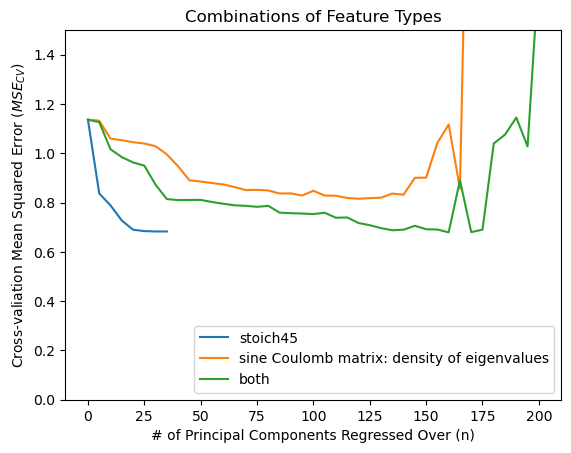

In [84]:
cv_mses = compare_feature_sets_PCA(df_train, [cols_stoich45, cols_sineSSD, cols_stoich45 + cols_sineSSD], 'outputs.hse06.bandgap', np.arange(5,205,5), 8)
plt.plot(cv_mses[:,0],cv_mses[:,1:])
plt.ylim((0,1.5))
plt.xlabel('# of Principal Components Regressed Over (n)')
plt.ylabel('Cross-valiation Mean Squared Error ($MSE_{CV}$)')
plt.legend(['stoich45', 'sine Coulomb matrix: density of eigenvalues', 'both'], loc='lower right')
plt.title('Combinations of Feature Types')
plt.show()

n = 5
n = 10
n = 15
n = 20
n = 25
n = 30
n = 35
n = 40
n = 45
n = 50
n = 55
n = 60
n = 65
n = 70
n = 75
n = 80
n = 85
n = 90
n = 95
n = 100
n = 105
n = 110
n = 115
n = 120
n = 125
n = 130
n = 135
n = 140
n = 145
n = 150
n = 155
n = 160
n = 165
n = 170
n = 175
n = 180
n = 185
n = 190
n = 195
n = 200


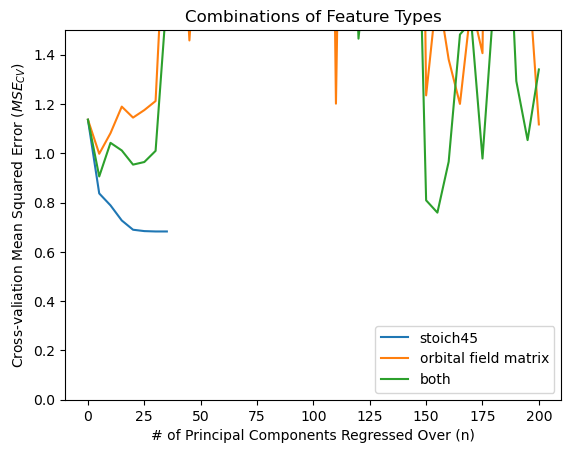

In [83]:
cv_mses = compare_feature_sets_PCA(df_train, [cols_stoich45, cols_ofm, cols_stoich45 + cols_ofm], 'outputs.hse06.bandgap', np.arange(5,205,5), 8)
plt.plot(cv_mses[:,0],cv_mses[:,1:])
plt.ylim((0,1.5))
plt.xlabel('# of Principal Components Regressed Over (n)')
plt.ylabel('Cross-valiation Mean Squared Error ($MSE_{CV}$)')
plt.legend(['stoich45', 'orbital field matrix', 'both'], loc='lower right')
plt.title('Combinations of Feature Types')
plt.show()